In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
import seaborn as sns
import emm
import warnings
import sklearn as sk
warnings.filterwarnings('ignore')

# Plot styles
plt.style.use('seaborn-notebook')

import matplotlib.pyplot as plt

SMALL_SIZE = 15
MEDIUM_SIZE = 16
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
processed_dir = "../assets/data/processed/pima_diabetes/"
# Get data into dataframe
df = pd.read_csv(processed_dir + "diabetes.csv",index_col=0)

# Replace 0 with nan
nan_cols = ['Glucose', 'BloodPressure','SkinThickness','Insulin','BMI']
df[nan_cols]=df[nan_cols].replace({'0':np.nan,0:np.nan})

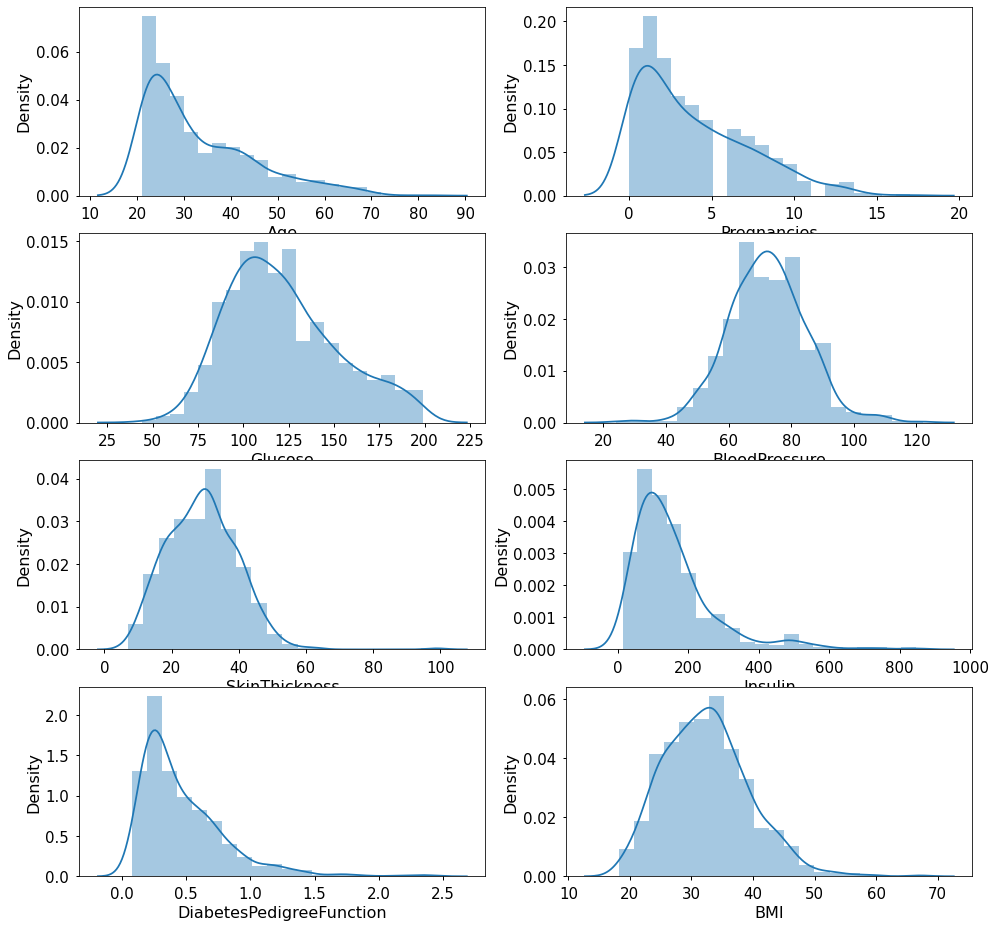

In [3]:
fig, ax = plt.subplots(4,2, figsize=(16,16))
sns.distplot(df.Age, bins = 20, ax=ax[0,0]) 
sns.distplot(df.Pregnancies, bins = 20, ax=ax[0,1]) 
sns.distplot(df.Glucose, bins = 20, ax=ax[1,0]) 
sns.distplot(df.BloodPressure, bins = 20, ax=ax[1,1]) 
sns.distplot(df.SkinThickness, bins = 20, ax=ax[2,0])
sns.distplot(df.Insulin, bins = 20, ax=ax[2,1])
sns.distplot(df.DiabetesPedigreeFunction, bins = 20, ax=ax[3,0]) 
sns.distplot(df.BMI, bins = 20, ax=ax[3,1]) 
plt.show()

In [23]:
marginals_mean = df.groupby('Outcome').mean()
m_0 = marginals_mean.loc[0]
m_1 = marginals_mean.loc[1]
display(marginals_mean.T)
print(marginals_mean.T.round(2).to_latex())

Outcome,0,1
Pregnancies,3.298000,4.865672
Glucose,110.643863,142.319549
BloodPressure,70.877339,75.321429
SkinThickness,27.235457,33.000000
Insulin,130.287879,206.846154
BMI,30.859674,35.406767
DiabetesPedigreeFunction,0.429734,0.550500
Age,31.190000,37.067164


\begin{tabular}{lrr}
\toprule
Outcome &       0 &       1 \\
\midrule
Pregnancies              &    3.30 &    4.87 \\
Glucose                  &  110.64 &  142.32 \\
BloodPressure            &   70.88 &   75.32 \\
SkinThickness            &   27.24 &   33.00 \\
Insulin                  &  130.29 &  206.85 \\
BMI                      &   30.86 &   35.41 \\
DiabetesPedigreeFunction &    0.43 &    0.55 \\
Age                      &   31.19 &   37.07 \\
\bottomrule
\end{tabular}



In [5]:
df[df['Outcome']==1].shape[0] / df.shape[0]

0.3489583333333333

In [25]:
from emm.losses import LeastSquaresLoss
from emm.losses import CorpusKLLoss
from emm.losses import EqualityLoss
loss_gl0 = CorpusKLLoss(m_0['Glucose'])
loss_gl1 = CorpusKLLoss(m_1['Glucose'])
loss_bmi0 = CorpusKLLoss(m_0['BMI'])
loss_bmi1 =CorpusKLLoss(m_1['BMI'])
loss_age0 = CorpusKLLoss(m_0['Age'])
loss_age1 = CorpusKLLoss(m_1['Age'])


# margs = {0 : [emm.reweighting.marginal('Glucose', loss_gl0.fun, loss_gl0),
#               emm.reweighting.marginal('BMI', loss_gl1.fun, loss_gl1),
#              emm.reweighting.marginal('Age', loss_bmi0.fun, loss_bmi0)],
#          1 : [emm.reweighting.marginal('Glucose', loss_bmi1.fun, loss_bmi1),
#               emm.reweighting.marginal('BMI', loss_age0.fun, loss_age0),
#              emm.reweighting.marginal('Age', loss_age1.fun, loss_age1)]
#         }

            

margs = {0 : [emm.reweighting.marginal('Glucose', 'mean', LeastSquaresLoss(m_0['Glucose']),True),
              emm.reweighting.marginal('BMI', 'mean', LeastSquaresLoss(m_0['BMI']),True),
             emm.reweighting.marginal('Age', 'mean', LeastSquaresLoss(m_0['Age']),True)],
         1 : [emm.reweighting.marginal('Glucose', 'mean', LeastSquaresLoss(m_1['Glucose'], scale=100),True),
              emm.reweighting.marginal('BMI', 'mean', LeastSquaresLoss(m_1['BMI'], scale=100),True),
             emm.reweighting.marginal('Age', 'mean', LeastSquaresLoss(m_1['Age'], scale =100),True)]
        }

# margs = {0 : [emm.reweighting.marginal('Glucose', 'mean', EqualityLoss(m_0['Glucose'])),
#               emm.reweighting.marginal('BMI', 'mean', EqualityLoss(m_0['BMI'])),
#              emm.reweighting.marginal('Age', 'mean', EqualityLoss(m_0['Age']))],
#          1 : [emm.reweighting.marginal('Glucose', 'mean', EqualityLoss(m_1['Glucose'])),
#               emm.reweighting.marginal('BMI', 'mean', EqualityLoss(m_1['BMI'])),
#              emm.reweighting.marginal('Age', 'mean', EqualityLoss(m_1['Age']))]
#         }
            

target = df
corpus = df.drop(columns = 'Outcome')
from sklearn.linear_model import LogisticRegression
param_grid_log =  {"classifier" : [LogisticRegression()],
                   "classifier__C" : np.logspace(-3,3,5)}

from sklearn.tree import DecisionTreeClassifier
param_grid_tree =  {'classifier' : [DecisionTreeClassifier()],
     'classifier__max_depth' : [5,10,20,50]}

from sklearn.ensemble import RandomForestClassifier
param_grid_rf  = {'classifier' : [RandomForestClassifier()],
    'classifier__bootstrap': [True],
    'classifier__max_depth': [5,10,20,50],
    'classifier__max_features' : ['sqrt'],
    'classifier__n_estimators': [200,300,400]
}
param_grid = [param_grid_log, param_grid_tree, param_grid_rf]

from sklearn.impute import SimpleImputer    
pipe = [("imputer", SimpleImputer())]
    
(rw_corpus, js, ml) = emm.metrics.multiple_models(target,corpus,margs, 
                                           param_grid, regularizer = emm.regularizers.EntropyRegularizer(), 
                                           lam=0.01, verbose=True, pipeline_steps = pipe, 
                                           scoring = sk.metrics.roc_auc_score, metrics=[sk.metrics.accuracy_score, sk.metrics.roc_auc_score, sk.metrics.confusion_matrix])

CVX took 0.10076 seconds
CVX took 0.05286 seconds
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Target data: the best parameters are given by 
 LogisticRegression()
 the best mean cross-validation accuracy 82.5095 +/- 4.52461% on training dataset 

Weighted data: the best parameters are given by 
 LogisticRegression()
 the best mean cross-validation accuracy 79.69082 +/- 2.12909% on training dataset 

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Target data: the best parameters are given by 
 DecisionTreeClassifier(max_depth=5)
 the best mean cross-validation accuracy 74.98986 +/- 3.57339% on training dataset 

Weighted data: the best parameters are given by 
 DecisionTreeClassifier(max_depth=5)
 the best mean cross-validation accuracy 58.75179 +/- 1.73932% on training dataset 

Fitting 5 folds for each of 12 candidates, totalling 60 fits


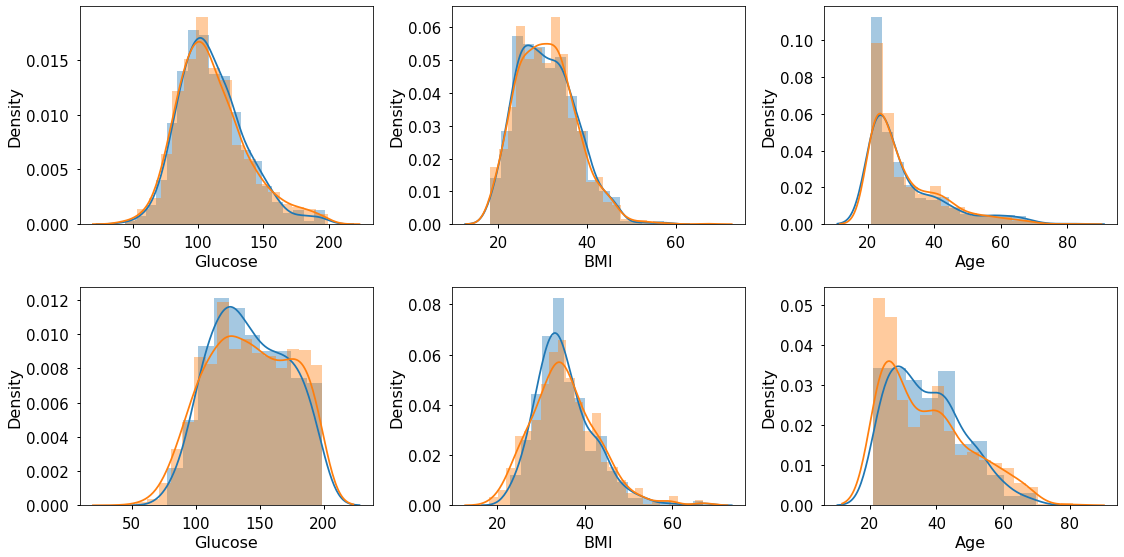

In [26]:
fig, ax = plt.subplots(2,3, figsize=(16,8))


sns.distplot(df[df['Outcome']==0].Glucose, bins = 'auto', ax=ax[0,0]) 
sns.distplot(df[df['Outcome']==0].BMI, bins = 'auto', ax=ax[0,1]) 
sns.distplot(df[df['Outcome']==0].Age, bins = 'auto', ax=ax[0,2])

emm.utils.weighted_hist(rw_corpus[rw_corpus['Outcome']==0].Glucose, rw_corpus[rw_corpus['Outcome']==0].weights, ax=ax[0,0])
emm.utils.weighted_hist(rw_corpus[rw_corpus['Outcome']==0].BMI, rw_corpus[rw_corpus['Outcome']==0].weights, ax=ax[0,1])
emm.utils.weighted_hist(rw_corpus[rw_corpus['Outcome']==0].Age, rw_corpus[rw_corpus['Outcome']==0].weights, ax=ax[0,2])

sns.distplot(df[df['Outcome']==1].Glucose, bins = 'auto', ax=ax[1,0]) 
sns.distplot(df[df['Outcome']==1].BMI, bins = 'auto', ax=ax[1,1]) 
sns.distplot(df[df['Outcome']==1].Age, bins = 'auto', ax=ax[1,2])

emm.utils.weighted_hist(rw_corpus[rw_corpus['Outcome']==1].Glucose, rw_corpus[rw_corpus['Outcome']==1].weights, ax=ax[1,0])
emm.utils.weighted_hist(rw_corpus[rw_corpus['Outcome']==1].BMI, rw_corpus[rw_corpus['Outcome']==1].weights, ax=ax[1,1])
emm.utils.weighted_hist(rw_corpus[rw_corpus['Outcome']==1].Age, rw_corpus[rw_corpus['Outcome']==1].weights, ax=ax[1,2])
plt.tight_layout()
plt.show()

In [27]:
ax

array([[<AxesSubplot:xlabel='Glucose', ylabel='Density'>,
        <AxesSubplot:xlabel='BMI', ylabel='Density'>,
        <AxesSubplot:xlabel='Age', ylabel='Density'>],
       [<AxesSubplot:xlabel='Glucose', ylabel='Density'>,
        <AxesSubplot:xlabel='BMI', ylabel='Density'>,
        <AxesSubplot:xlabel='Age', ylabel='Density'>]], dtype=object)

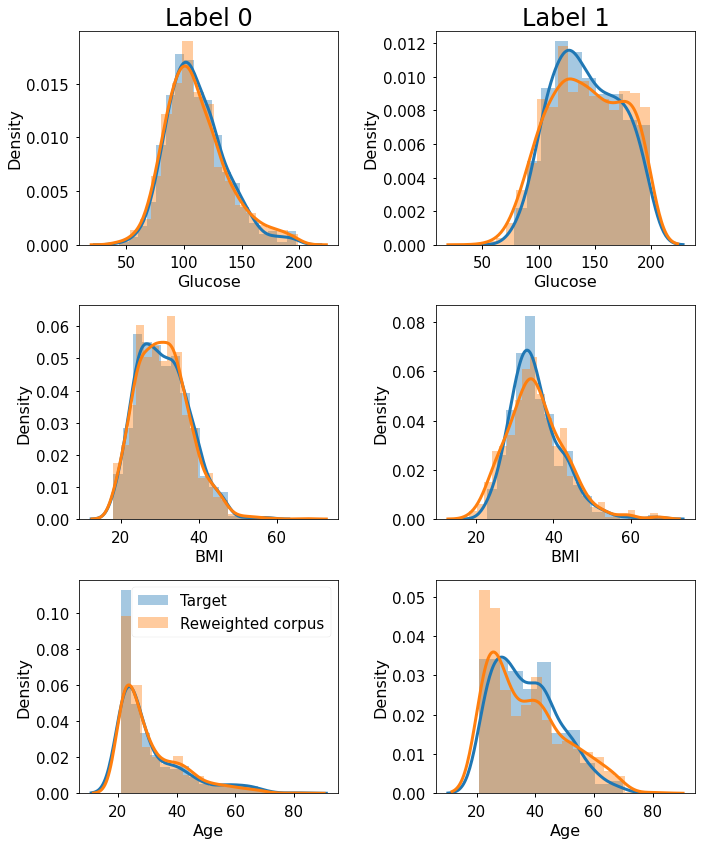

In [28]:
fig, ax = plt.subplots( figsize=(10, 12) , nrows=3, ncols=2) 

ax = ax.flatten()



sns.distplot(df[df['Outcome']==0].Glucose, bins = 'auto', ax=ax[0], label='Target', kde_kws={'linewidth':3}) 
sns.distplot(df[df['Outcome']==0].BMI, bins = 'auto', ax=ax[2], label='Target', kde_kws={'linewidth':3}) 
sns.distplot(df[df['Outcome']==0].Age, bins = 'auto', ax=ax[4],label='Target', kde_kws={'linewidth':3})

emm.utils.weighted_hist(rw_corpus[rw_corpus['Outcome']==0].Glucose, rw_corpus[rw_corpus['Outcome']==0].weights, ax=ax[0],label='Reweighted corpus', kde_kws={'linewidth':3})
emm.utils.weighted_hist(rw_corpus[rw_corpus['Outcome']==0].BMI, rw_corpus[rw_corpus['Outcome']==0].weights, ax=ax[2], label='Reweighted corpus', kde_kws={'linewidth':3})
emm.utils.weighted_hist(rw_corpus[rw_corpus['Outcome']==0].Age, rw_corpus[rw_corpus['Outcome']==0].weights, ax=ax[4],label='Reweighted corpus', kde_kws={'linewidth':3})

ax[4].legend()

sns.distplot(df[df['Outcome']==1].Glucose, bins = 'auto', ax=ax[1], kde_kws={'linewidth':3}) 
sns.distplot(df[df['Outcome']==1].BMI, bins = 'auto', ax=ax[3], kde_kws={'linewidth':3}) 
sns.distplot(df[df['Outcome']==1].Age, bins = 'auto', ax=ax[5], kde_kws={'linewidth':3})

emm.utils.weighted_hist(rw_corpus[rw_corpus['Outcome']==1].Glucose, rw_corpus[rw_corpus['Outcome']==1].weights, ax=ax[1], kde_kws={'linewidth':3})
emm.utils.weighted_hist(rw_corpus[rw_corpus['Outcome']==1].BMI, rw_corpus[rw_corpus['Outcome']==1].weights, ax=ax[3], kde_kws={'linewidth':3})
emm.utils.weighted_hist(rw_corpus[rw_corpus['Outcome']==1].Age, rw_corpus[rw_corpus['Outcome']==1].weights, ax=ax[5], kde_kws={'linewidth':3})    

fig.set_facecolor('w')
#plt.suptitle('Marginal feature distribution for target and reweighted corpus')
ax[0].set_title('Label 0', fontsize=24)
ax[1].set_title('Label 1', fontsize=24)
plt.tight_layout()
plt.savefig('PIMA_dist_reweighted.jpg')
plt.show()

In [29]:
ml

[[{'accuracy_score': 'LogisticRegression',
   'RR': 0.7402597402597403,
   'RS': 0.7029491800975453,
   'SS': 0.6858445313188306,
   'SR': 0.7272727272727273},
  {'roc_auc_score': 'LogisticRegression',
   'RR': 0.8265509133658889,
   'RS': 0.7656708670909163,
   'SS': 0.7603604418480979,
   'SR': 0.8251039971061674},
  {'confusion_matrix': 'LogisticRegression',
   'RR': array([[85, 12],
          [28, 29]], dtype=int64),
   'RS': array([[0.17744831, 0.03027915],
          [0.0832432 , 0.09119408]]),
   'SS': array([[0.1411287 , 0.06659876],
          [0.05346038, 0.1209769 ]]),
   'SR': array([[70, 27],
          [15, 42]], dtype=int64)}],
 [{'accuracy_score': 'DecisionTreeClassifier',
   'RR': 0.7142857142857143,
   'RS': 0.7069669370957675,
   'SS': 0.6151521892161654,
   'SR': 0.7077922077922078},
  {'roc_auc_score': 'DecisionTreeClassifier',
   'RR': 0.775323275862069,
   'RS': 0.7509710154023366,
   'SS': 0.6279799874390569,
   'SR': 0.7916666666666666},
  {'confusion_matrix': 'De

In [11]:
js

{1: {'Pregnancies': 0.06917241706226288,
  'Glucose': 0.07420454543702473,
  'BloodPressure': 0.0671831979534661,
  'SkinThickness': 0.08077274878191311,
  'Insulin': 0.16735024185173242,
  'BMI': 0.10381497148476954,
  'DiabetesPedigreeFunction': 0.11390883445754145,
  'Age': 0.12173394374546066},
 0: {'Pregnancies': 0.043329007679309896,
  'Glucose': 0.06652410067617888,
  'BloodPressure': 0.04771782906084261,
  'SkinThickness': 0.033186152471386975,
  'Insulin': 0.07113282319337454,
  'BMI': 0.044726456179059806,
  'DiabetesPedigreeFunction': 0.06909610213249469,
  'Age': 0.06929221131755206}}

In [12]:
print(pd.DataFrame(js).to_latex())

\begin{tabular}{lrr}
\toprule
{} &         1 &         0 \\
\midrule
Pregnancies              &  0.069172 &  0.043329 \\
Glucose                  &  0.074205 &  0.066524 \\
BloodPressure            &  0.067183 &  0.047718 \\
SkinThickness            &  0.080773 &  0.033186 \\
Insulin                  &  0.167350 &  0.071133 \\
BMI                      &  0.103815 &  0.044726 \\
DiabetesPedigreeFunction &  0.113909 &  0.069096 \\
Age                      &  0.121734 &  0.069292 \\
\bottomrule
\end{tabular}



In [13]:
m = len(corpus)
base_test = pd.concat([corpus.copy(), corpus.copy()], ignore_index=True)
base_test['weights'] = np.ones(2*m) /(2*m)
base_test['Outcome'] = np.concatenate([np.zeros(m), np.ones(m)],axis=0)
emm.compute_js_distance(target,base_test)

{1: {'Pregnancies': 0.13655453930100142,
  'Glucose': 0.27015996359310723,
  'BloodPressure': 0.13404055611298185,
  'SkinThickness': 0.19075627022870495,
  'Insulin': 0.2697379113122689,
  'BMI': 0.1826337455228975,
  'DiabetesPedigreeFunction': 0.14236893400748657,
  'Age': 0.20484811373336934},
 0: {'Pregnancies': 0.08915841057606871,
  'Glucose': 0.17921122125469055,
  'BloodPressure': 0.0822732503422884,
  'SkinThickness': 0.08220369511579462,
  'Insulin': 0.13489136860556752,
  'BMI': 0.11083837473649959,
  'DiabetesPedigreeFunction': 0.08721705585628159,
  'Age': 0.1189210706802312}}

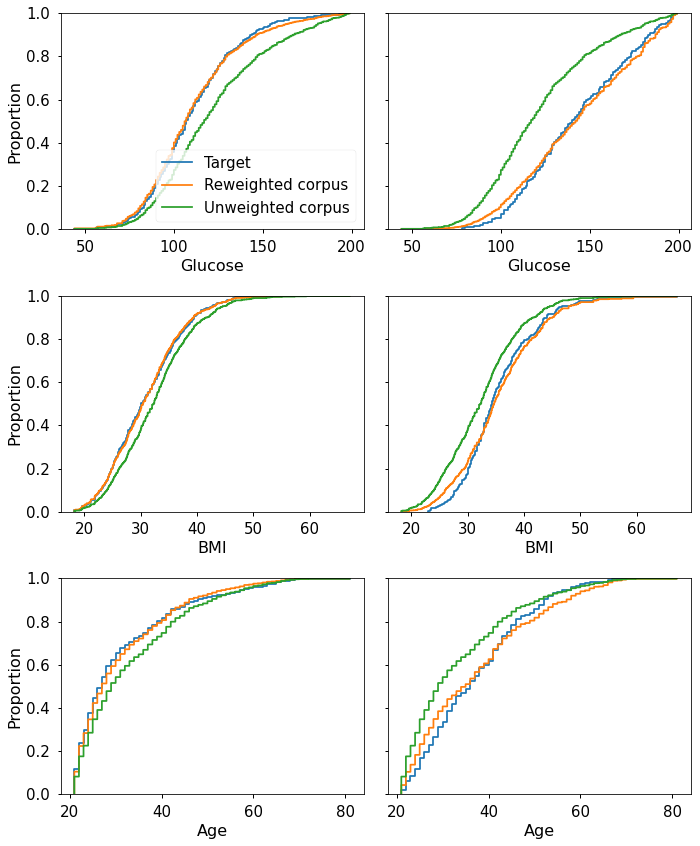

In [14]:
fig, ax = plt.subplots(figsize=(10, 12) , nrows=3, ncols=2, sharey=True) 
ax = ax.flatten()
    

sns.ecdfplot(df[df['Outcome']==0].Glucose, ax=ax[0], label='Target') 
sns.ecdfplot(df[df['Outcome']==0].BMI, ax=ax[2], label='Target') 
sns.ecdfplot(df[df['Outcome']==0].Age, ax=ax[4], label='Target')

sns.ecdfplot(x=rw_corpus[rw_corpus['Outcome']==0].Glucose, weights=rw_corpus[rw_corpus['Outcome']==0].weights, ax=ax[0], label='Reweighted corpus')
sns.ecdfplot(x=rw_corpus[rw_corpus['Outcome']==0].BMI, weights=rw_corpus[rw_corpus['Outcome']==0].weights, ax=ax[2], label='Reweighted corpus')
sns.ecdfplot(x=rw_corpus[rw_corpus['Outcome']==0].Age, weights=rw_corpus[rw_corpus['Outcome']==0].weights, ax=ax[4], label='Reweighted corpus')

sns.ecdfplot(x=rw_corpus[rw_corpus['Outcome']==0].Glucose, ax=ax[0], label='Unweighted corpus')
sns.ecdfplot(x=rw_corpus[rw_corpus['Outcome']==0].BMI, ax=ax[2], label='Unweighted corpus')
sns.ecdfplot(x=rw_corpus[rw_corpus['Outcome']==0].Age, ax=ax[4], label='Unweighted corpus')

ax[0].legend()

sns.ecdfplot(df[df['Outcome']==1].Glucose, ax=ax[1]) 
sns.ecdfplot(df[df['Outcome']==1].BMI, ax=ax[3]) 
sns.ecdfplot(df[df['Outcome']==1].Age, ax=ax[5])

sns.ecdfplot(x=rw_corpus[rw_corpus['Outcome']==1].Glucose, weights=rw_corpus[rw_corpus['Outcome']==1].weights, ax=ax[1])
sns.ecdfplot(x=rw_corpus[rw_corpus['Outcome']==1].BMI, weights=rw_corpus[rw_corpus['Outcome']==1].weights, ax=ax[3])
sns.ecdfplot(x=rw_corpus[rw_corpus['Outcome']==1].Age, weights=rw_corpus[rw_corpus['Outcome']==1].weights, ax=ax[5])    

sns.ecdfplot(x=rw_corpus[rw_corpus['Outcome']==1].Glucose, ax=ax[1])
sns.ecdfplot(x=rw_corpus[rw_corpus['Outcome']==1].BMI, ax=ax[3])
sns.ecdfplot(x=rw_corpus[rw_corpus['Outcome']==1].Age, ax=ax[5])  

fig.set_facecolor('w')
#plt.suptitle('Conditional feature CDF for target, reweighted corpus, unweighted corpus')

plt.tight_layout()
plt.savefig('PIMA_cdf_reweighted.jpg')
plt.show()

In [15]:
print(emm.utils.weighted_mean(rw_corpus.drop(columns=['Outcome', 'weights']), rw_corpus['weights']))

Pregnancies                  3.929701
Glucose                           NaN
BloodPressure                     NaN
SkinThickness                     NaN
Insulin                           NaN
BMI                               NaN
DiabetesPedigreeFunction     0.487386
Age                         34.131253
dtype: float64


In [22]:
target['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [24]:
corpus.mean()

Pregnancies                   3.845052
Glucose                     121.686763
BloodPressure                72.405184
SkinThickness                29.153420
Insulin                     155.548223
BMI                          32.457464
DiabetesPedigreeFunction      0.471876
Age                          33.240885
dtype: float64

In [31]:
base_test = pd.concat([corpus.copy(), corpus.copy()], ignore_index=True)
base_test['weights'] = np.ones(2*m) /(2*m)
base_test['Outcome'] = np.concatenate([np.zeros(m), np.ones(m)],axis=0)
emm.compute_js_distance(target,base_test)

{1: {'Pregnancies': 0.13655453930100142,
  'Glucose': 0.27015996359310723,
  'BloodPressure': 0.13404055611298185,
  'SkinThickness': 0.19075627022870495,
  'Insulin': 0.2697379113122689,
  'BMI': 0.1826337455228975,
  'DiabetesPedigreeFunction': 0.14236893400748657,
  'Age': 0.20484811373336934},
 0: {'Pregnancies': 0.08915841057606871,
  'Glucose': 0.17921122125469055,
  'BloodPressure': 0.0822732503422884,
  'SkinThickness': 0.08220369511579462,
  'Insulin': 0.13489136860556752,
  'BMI': 0.11083837473649959,
  'DiabetesPedigreeFunction': 0.08721705585628159,
  'Age': 0.1189210706802312}}

In [33]:
marginals_mean

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,3.298000,110.643863,70.877339,27.235457,130.287879,30.859674,0.429734,31.190000
1,4.865672,142.319549,75.321429,33.000000,206.846154,35.406767,0.550500,37.067164
